In [ ]:
from google.colab import drive
import os

MOUNT = True

if MOUNT:
  drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
FILEPATH = "/content/gdrive/MyDrive/HackYeah 2023 - dane/ML/raw"


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [50]:
data = pd.read_csv(f'{FILEPATH}/parsed.csv')
unscaled_df = pd.read_csv(f"{FILEPATH}/states_all.csv")
features = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE', 'GRADES_8_G', 'AVG_MATH_8_SCORE', 'AVG_READING_8_SCORE', 'DIFFERENCE', 'EXPENDITURE_PER_STUDENT', 'REVENUE_PER_STUDENT', 'REVENUE_EXPENDITURE_RATIO']
scaled_data = data[features]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

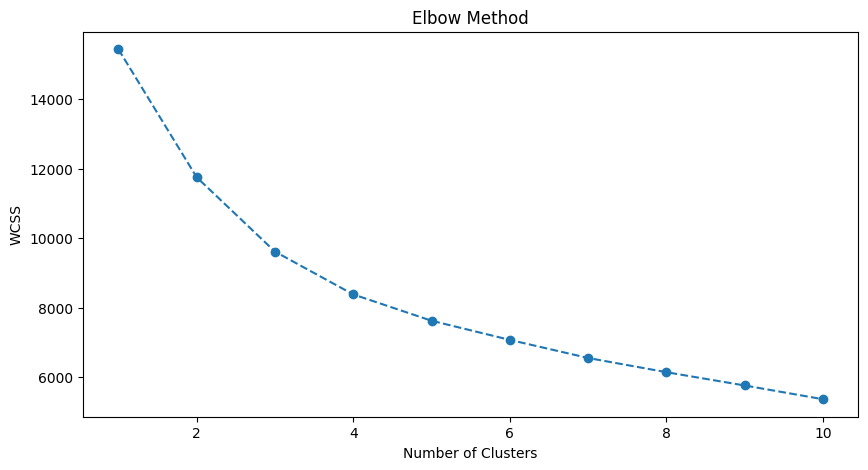

In [ ]:
wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_data)

data['Cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)


                YEAR  TOTAL_REVENUE  TOTAL_EXPENDITURE  GRADES_8_G  \
Cluster                                                              
0        2010.551020       0.188278           0.160492   -0.156995   
1        1999.644615      -0.255621          -0.251494   -0.143024   
2        2005.583333       3.718436           3.776290    3.330287   

         AVG_MATH_8_SCORE  AVG_READING_8_SCORE  DIFFERENCE  \
Cluster                                                      
0                0.513367             0.382451    0.445386   
1               -0.130695            -0.077885    0.034628   
2               -0.085852            -0.415703   -2.746997   

         EXPENDITURE_PER_STUDENT  REVENUE_PER_STUDENT  \
Cluster                                                 
0                       1.354396             1.412363   
1                      -0.396354            -0.405203   
2                       0.704203             0.587827   

         REVENUE_EXPENDITURE_RATIO  
Cluster        

<ipython-input-11-19bd3e3d381e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby('Cluster').mean()


In [ ]:
sns.pairplot(data=data, hue='Cluster', vars=features, palette="deep")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Anomaly detection

In [ ]:
# Convert the scaled_data DataFrame back to a numpy array
scaled_data_array = scaled_data.values

# Now compute the distance to the cluster center for each row in the array
data['Distance_to_Center'] = [np.linalg.norm(a - kmeans.cluster_centers_[cluster]) for a, cluster in zip(scaled_data_array, clusters)]
data["Distance_to_Center"]

0       4.787828
1       2.488015
2       2.723849
3       4.180987
4       4.970944
          ...   
1710    1.480964
1711    1.294704
1712    2.446307
1713    1.821797
1714    1.226368
Name: Distance_to_Center, Length: 1715, dtype: float64

In [ ]:
threshold = np.percentile(data['Distance_to_Center'], 98)  # Adjust percentile based on desired sensitivity
data['Anomaly'] = data['Distance_to_Center'] > threshold


In [ ]:
anomalies = data[data['Anomaly'] == True]
print(anomalies)


                     STATE  YEAR  TOTAL_REVENUE  TOTAL_EXPENDITURE  \
8     DISTRICT_OF_COLUMBIA  1992      -0.715734          -0.710511   
94                   TEXAS  1993       1.185627           0.990944   
259             CALIFORNIA  1997       2.677701           2.449607   
310             CALIFORNIA  1998       3.024583           2.852776   
314   DISTRICT_OF_COLUMBIA  1998      -0.715981          -0.713006   
412             CALIFORNIA  2000       3.748388           3.591494   
416   DISTRICT_OF_COLUMBIA  2000      -0.699018          -0.699451   
463             CALIFORNIA  2001       4.395931           4.188110   
470                 HAWAII  2001      -0.621156          -0.651327   
518   DISTRICT_OF_COLUMBIA  2002      -0.674062          -0.672078   
521                 HAWAII  2002      -0.601005          -0.644316   
565             CALIFORNIA  2003       5.030464           4.919697   
569   DISTRICT_OF_COLUMBIA  2003      -0.676402          -0.675868   
572                 

In [ ]:
record = scaled_data_array[8]
cluster_center = kmeans.cluster_centers_[clusters[8]]

# Calculate feature-wise differences
feature_diff = record - cluster_center

# Convert to a DataFrame for better visualization
diff_df = pd.DataFrame({
    'Feature': features,
    'Difference_from_Center': feature_diff
})

# Sort by the absolute difference
diff_df = diff_df.iloc[abs(diff_df['Difference_from_Center']).argsort()[::-1]]

print(diff_df)


                     Feature  Difference_from_Center
3           AVG_MATH_8_SCORE               -7.066058
8  REVENUE_EXPENDITURE_RATIO               -0.895833
6    EXPENDITURE_PER_STUDENT                0.859934
7        REVENUE_PER_STUDENT                0.729951
2                 GRADES_8_G               -0.672767
0              TOTAL_REVENUE               -0.460114
1          TOTAL_EXPENDITURE               -0.459017
4        AVG_READING_8_SCORE                0.200815
5                 DIFFERENCE                0.065171


# Spends more than

In [ ]:
from sklearn.cluster import KMeans

# Select relevant features for clustering
X = data[['GRADES_8_G', 'AVG_MATH_8_SCORE', 'AVG_READING_8_SCORE']]

# Perform clustering; let's use 5 clusters as a starting point (adjust based on your preference and dataset)
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
def school_comparison(school_index):
    school_data = data.iloc[school_index]
    school_expenditure = school_data['TOTAL_EXPENDITURE']

    # Extracting cluster of the given school
    cluster_label = school_data['Cluster']

    # Calculating the average expenditure for schools in the same cluster
    cluster_avg_expenditure = data[data['Cluster'] == cluster_label]['TOTAL_EXPENDITURE'].mean()

    difference_percentage = ((school_expenditure - cluster_avg_expenditure) / cluster_avg_expenditure) * 100

    if difference_percentage > 0 and school_expenditure > 0:
        return f"Your school spends {difference_percentage:.2f}% more than similar schools."
    else:
        return f"Your school spends {-difference_percentage:.2f}% less than similar schools."

# Example usage



Your school spends -105.03% less than similar schools.


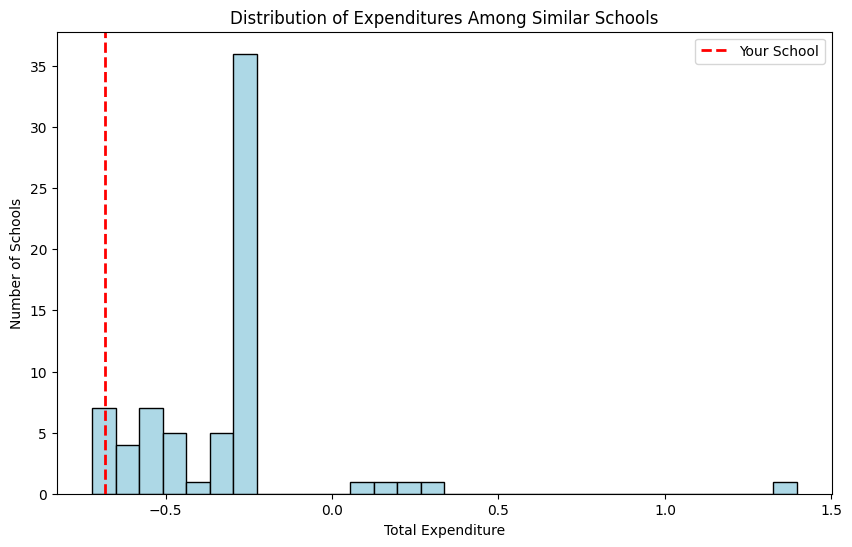

In [49]:
def visualize_school_histogram(school_index):
    school_data = data.iloc[school_index]
    cluster_label = school_data['Cluster']

    cluster_data = data[data['Cluster'] == cluster_label]

    plt.figure(figsize=(10, 6))

    plt.hist(cluster_data['TOTAL_EXPENDITURE'], bins=30, color='lightblue', edgecolor='black')
    plt.axvline(school_data['TOTAL_EXPENDITURE'], color='red', linestyle='dashed', linewidth=2, label='Your School')

    plt.title('Distribution of Expenditures Among Similar Schools')
    plt.xlabel('Total Expenditure')
    plt.ylabel('Number of Schools')
    plt.legend()

    plt.show()

school_index = 11  # Change this index to refer to the specific school of interest
print(school_comparison(school_index))
visualize_school_histogram(school_index)

# for school_index in range(6, 15):
#   print(school_index)
#   print(school_comparison(school_index))
  # visualize_school_histogram(school_index)


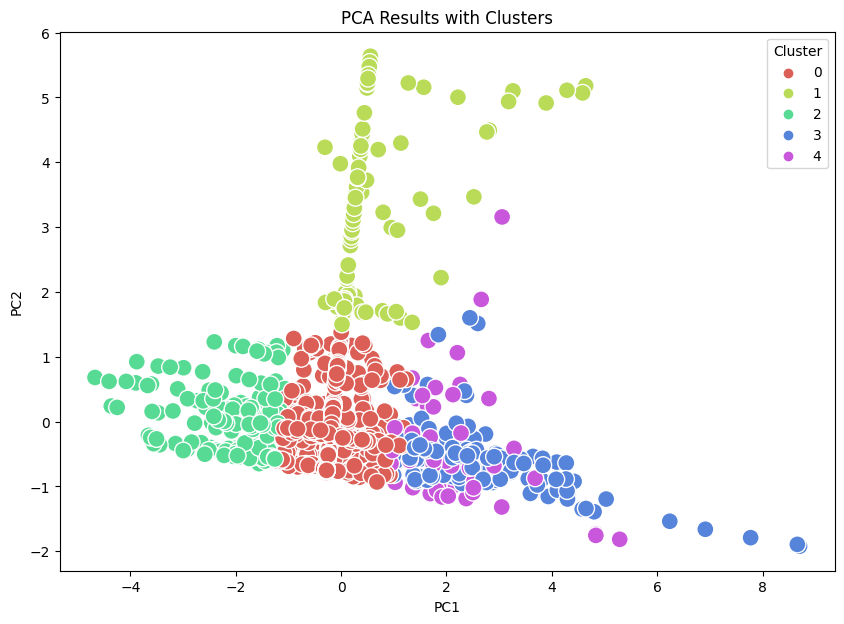

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data[['GRADES_8_G', 'AVG_MATH_8_SCORE', 'AVG_READING_8_SCORE']])
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = data['Cluster']

# Visualizing 2D PCA results with clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pc_df['PC1'], y=pc_df['PC2'], hue=pc_df['Cluster'], palette=sns.color_palette('hls', n_colors=len(pc_df['Cluster'].unique())), edgecolor='w', s=150)
plt.title('PCA Results with Clusters')
plt.show()


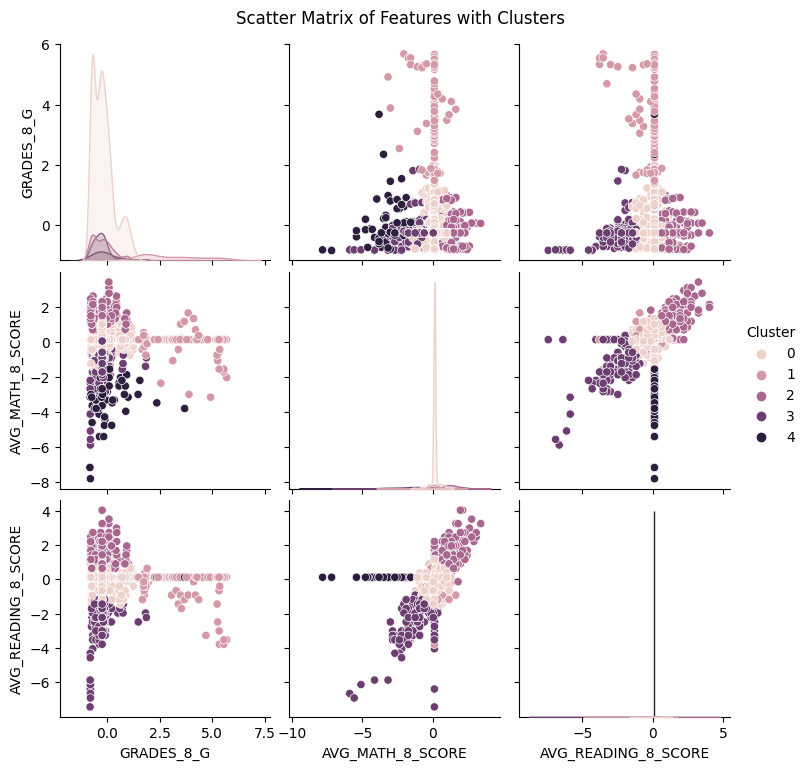

In [ ]:
sns.pairplot(data=data, hue='Cluster', vars=['GRADES_8_G', 'AVG_MATH_8_SCORE', 'AVG_READING_8_SCORE'])
plt.suptitle('Scatter Matrix of Features with Clusters', y=1.02)
plt.show()


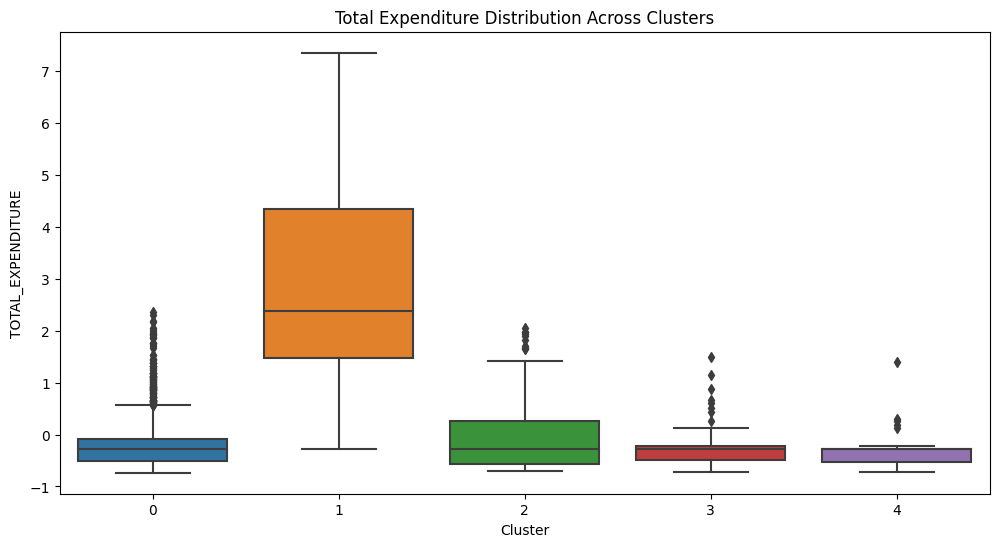

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Cluster'], y=data['TOTAL_EXPENDITURE'])
plt.title('Total Expenditure Distribution Across Clusters')
plt.show()
